In [8]:
import datetime
import itertools

import matplotlib.pyplot as plt
import pandas as pd

import bitmex_basis_rate

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline


In [9]:
# Get market price data for the underlying bitcoin index and the futures
num_days = 150
end_date = datetime.date.today() - datetime.timedelta(days=1)
start_date = end_date - datetime.timedelta(days=num_days)
  
contract_expirations = bitmex_basis_rate.GetContractExpirations(start_date, num_days)
index_prices, futures_prices = bitmex_basis_rate.GetPrices(contract_expirations, start_date, num_days)
futures_basis = bitmex_basis_rate.GetBasisRates(contract_expirations, futures_prices, index_prices)

In [10]:
# Convert raw data into DataFrame objects
expiration_df = pd.DataFrame.from_records(zip(contract_expirations.keys(), contract_expirations.values()), 
                                          columns=['contract', 'expiry'])
index_price_df = pd.DataFrame.from_records(zip(index_prices.keys(), index_prices.values()), 
                                           columns=['date', 'price'])


In [11]:
# flatten {contract:{date:price}} to contract, date, price rows
fp_dfs = [pd.DataFrame.from_records(zip(prices.keys(), prices.values(), 
                                        itertools.repeat(contract, len(prices))), 
                                    columns=['date', 'price', 'contract'])
          for contract, prices in futures_prices.items()
]

futures_price_df = pd.concat(fp_dfs, ignore_index=True)

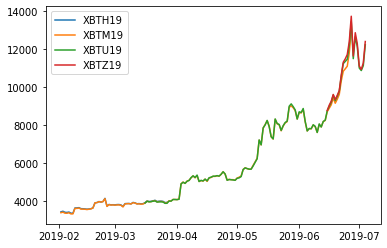

In [12]:
# Chart the daily closing prices of all the contracts on a single chart.
fig, ax = plt.subplots()
for key, grp in futures_price_df.groupby(['contract']):
    ax.plot(grp['date'], grp['price'], label=key)
ax.legend()



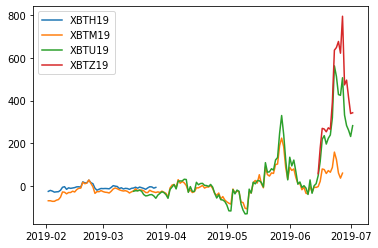

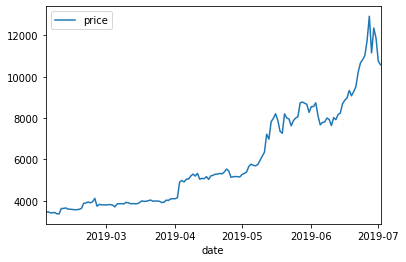

In [13]:
# Chart the delta between futures price and bitcoin index price
contracts_price_df = futures_price_df.merge(index_price_df, how='inner', on='date')
contracts_price_delta_df = contracts_price_df.assign(delta=lambda x: x.price_x - x.price_y)
contracts_price_delta_df.sort_values('date', ascending=False)
fig, ax = plt.subplots()
for key, grp in contracts_price_delta_df.groupby(['contract']):
    ax.plot(grp['date'], grp['delta'], label=key)
ax.legend()

# Chart the bitcoin index price
index_price_df.plot(x='date', y='price',label='price')




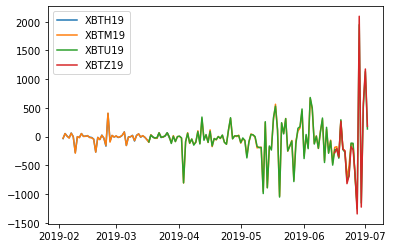

In [47]:
# Get the daily change in price for the futures
contracts_price_2day_df = contracts_price_df.assign(yesterday=lambda x: x.date - datetime.timedelta(days=1))
contracts_price_2day_df = contracts_price_2day_df.merge(
     contracts_price_2day_df, how='inner',left_on=['contract', 'yesterday'], right_on=['contract','date'])
contracts_price_2day_df = contracts_price_2day_df.assign(contract_price_delta=lambda x: x.price_x_y - x.price_x_x)

fig, ax = plt.subplots()
for key, grp in contracts_price_2day_df.groupby(['contract']):
    ax.plot(grp['date_x'], grp['contract_price_delta'], label=key)
ax.legend()

